In [ ]:
using CSV
using Dates
using DataFramesMeta

using PlotlyJS

include("storageOptimization.jl");
basepath = "../data"
include("$basepath/datacatalog.jl");

### Terminology
- Energy Capacity: The amount of "volumetric" energy a storage facility can store. Measured in megawatt-hours (MWh).
- Power Capacity (Power Rating): The rate at which a storage facility can charge from or discharge power to the grid. Measured in megawatts (MW).
- State of Charge (SOC): The amount of energy currently stored in the facility as a percent (%) of the Energy Capacity. 
- Round Trip Efficiency: The ratio of energy input into a storage facility to the energy output expressed as a percentage (%).
- Self Discharge: The amount of energy lost while the system is inactive. Units are % per hour.

Note: In this model Percentages (%) are expected to be an intergar between 0 and 100. 

In [2]:
# testPrices = rand(1.0:9.0, 24*12);

In [3]:
misoDAPrices = reduce(
    vcat,
    [
        # CSV.read("../Data/MISO DA Energy Price by Hub 2015.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        # CSV.read("../Data/MISO DA Energy Price by Hub 2016.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        # CSV.read("../Data/MISO DA Energy Price by Hub 2017.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        # CSV.read("../Data/MISO DA Energy Price by Hub 2018.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        # CSV.read("../Data/MISO DA Energy Price by Hub 2019.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        # CSV.read("../Data/MISO DA Energy Price by Hub 2020.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        # CSV.read("../Data/MISO DA Energy Price by Hub 2021.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        # CSV.read("../Data/MISO DA Energy Price by Hub 2022.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        CSV.read("$basepath/MISO DA Energy Price by Hub 2023.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
        CSV.read("$basepath/MISO DA Energy Price by Hub 2024.csv", DataFrame; dateformat=misoDAPriceByHub.dateformat, types=misoDAPriceByHub.schema, validate=true),
    ]
)
misoDAPrices = @chain misoDAPrices begin
    @rsubset :node == "MINN.HUB";
end;

In [4]:
analysisStart = DateTime(2023, 1, 1, 0, 0, 0)
analysisEnd = DateTime(2024, 1, 1, 0, 0, 0)
s = @rsubset misoDAPrices :interval_start_est >= analysisStart && :interval_start_est < analysisEnd
misoPrices = s.lmp;

In [5]:
zeroCapBonus = zeros(length(misoPrices));

In [6]:
raHours = CSV.read("$basepath/MISO RA Hours PY25.csv", DataFrame; dateformat="yyyy-mm-ddTHH:MM:SS.s");
raHours = @chain raHours begin
    @rsubset :interval_start_est >= analysisStart && :interval_start_est < analysisEnd
    @rtransform :capacityBonus = :ra_hour_north_central * 280.0
end;
misoCapBonus = raHours.capacityBonus;
zeroCapBonus = zeros(length(misoCapBonus));

In [7]:
config100HR = StorageModelConfig(100, 1, roundTripEfficency=40);
# config8HR = StorageModelConfig(80, 10, roundTripEfficency=85);
config4HR = StorageModelConfig(20, 5, roundTripEfficency=85);

In [8]:
solution100HR24F = solveRollingStorageOptimization(misoPrices, config100HR, 24, 24; socStart=0.0)
results100HR24F = parseSolution(solution100HR24F)
results100HR24F[!, :interval_start_est] = s.interval_start_est[1:length(s.interval_start_est)-24]
rename!(results100HR24F, :price => :minnHubLmp)
leftjoin!(results100HR24F, raHours, on=:interval_start_est)
@rtransform! results100HR24F :storageDispatch = :discharging - :charging;

solution100HR48F = solveRollingStorageOptimization(misoPrices, config100HR, 24, 48; socStart=0.0)
results100HR48F = parseSolution(solution100HR48F)
results100HR48F[!, :interval_start_est] = s.interval_start_est[1:length(s.interval_start_est)-48];
rename!(results100HR48F, :price => :minnHubLmp);
leftjoin!(results100HR48F, raHours, on=:interval_start_est);
@rtransform! results100HR48F :storageDispatch = :discharging - :charging;

solution100HR72F = solveRollingStorageOptimization(misoPrices, config100HR, 24, 72; socStart=0.0)
results100HR72F = parseSolution(solution100HR72F)
results100HR72F[!, :interval_start_est] = s.interval_start_est[1:length(s.interval_start_est)-72];
rename!(results100HR72F, :price => :minnHubLmp);
leftjoin!(results100HR72F, raHours, on=:interval_start_est);
@rtransform! results100HR72F :storageDispatch = :discharging - :charging;

solution100HR168F = solveRollingStorageOptimization(misoPrices, config100HR, 24, 168; socStart=0.0)
results100HR168F = parseSolution(solution100HR168F)
results100HR168F[!, :interval_start_est] = s.interval_start_est[1:length(s.interval_start_est)-168];
rename!(results100HR168F, :price => :minnHubLmp);
leftjoin!(results100HR168F, raHours, on=:interval_start_est);
@rtransform! results100HR168F :storageDispatch = :discharging - :charging;

solution100HR8760F = solveStorageOptimization(misoPrices, config100HR; socStart=0.0)
results100HR8760F = parseSolution(solution100HR8760F)
results100HR8760F[!, :interval_start_est] = s.interval_start_est;
rename!(results100HR8760F, :price => :minnHubLmp);
leftjoin!(results100HR8760F, raHours, on=:interval_start_est);
@rtransform! results100HR8760F :storageDispatch = :discharging - :charging;

In [9]:
solution100HR312F = solveRollingStorageOptimization(misoPrices, config100HR, 24, 312; socStart=0.0)
results100HR312F = parseSolution(solution100HR312F)
results100HR312F[!, :interval_start_est] = s.interval_start_est[1:length(s.interval_start_est)-312];
rename!(results100HR312F, :price => :minnHubLmp);
leftjoin!(results100HR312F, raHours, on=:interval_start_est);
@rtransform! results100HR312F :storageDispatch = :discharging - :charging;

In [10]:
solution100HR24F.revenue, solution100HR48F.revenue, solution100HR72F.revenue, solution100HR168F.revenue, solution100HR312F.revenue, solution100HR8760F.revenue

(10649.699, 12085.136, 12838.476000000004, 14452.304000000006, 15075.543999999993, 18568.582624000093)

In [11]:
# solution8HR_CB = rollingOptimization(misoPrices, config8HR, socStart=0.0, capacityBonus=misoCapBonus)
# results8HR_CB = parseSolution(solution8HR_CB)
# results8HR_CB[!, :interval_start_est] = s.interval_start_est[analysisRange[begin]:analysisRange[end]-48];
# rename!(results8HR_CB, :price => :minnHubLmp);
# leftjoin!(results8HR_CB, raHours, on=:interval_start_est);
# @rtransform! results8HR_CB :storageDispatch = :discharging - :charging;

In [12]:
# solution4HR = solveRollingStorageOptimization(misoPrices, config4HR, 24, 48; socStart=20.0, capacityBonus=zeroCapBonus)
# results4HR = parseSolution(solution4HR)
# results4HR[!, :interval_start_est] = s.interval_start_est[analysisRange[begin]:analysisRange[end]-48];
# rename!(results4HR, :price => :minnHubLmp);
# leftjoin!(results4HR, raHours, on=:interval_start_est);
# @rtransform! results4HR :storageDispatch = :discharging - :charging;

In [13]:
# solution4HR_CB = rollingOptimization(misoPrices, config4HR, socStart=0.0, capacityBonus=misoCapBonus)
# results4HR_CB = parseSolution(solution4HR_CB)
# results4HR_CB[!, :interval_start_est] = s.interval_start_est[analysisRange[begin]:analysisRange[end]-48];
# rename!(results4HR_CB, :price => :minnHubLmp);
# leftjoin!(results4HR_CB, raHours, on=:interval_start_est);
# @rtransform! results4HR_CB :storageDispatch = :discharging - :charging;

### PLOTS

In [14]:
# titleText = "100-Hr (1MW/100MWh) Iron Air Dispatch by Lookahead Period"

# seriesStart = DateTime(2024, 3, 1, 0, 0, 0)
# seriesEnd = DateTime(2024, 6, 1, 0, 0, 0)

# lmpSeries = @rsubset results100HR168F :interval_start_est >= seriesStart && :interval_start_est <= seriesEnd;
# dataSeries = [
#     # @rsubset(results100HR24F, :interval_start_est >= seriesStart && :interval_start_est <= seriesEnd),
#     # @rsubset(results100HR48F, :interval_start_est >= seriesStart && :interval_start_est <= seriesEnd),
#     @rsubset(results100HR8760F, :interval_start_est >= seriesStart && :interval_start_est <= seriesEnd),
#     @rsubset(results100HR168F, :interval_start_est >= seriesStart && :interval_start_est <= seriesEnd)
# ]

# subplotTitles = hcat([
#     "MISO DA LMP",
#     "Full Year Dispatch",
#     "Full Year SOC",
#     "168-Hr Lookahead Dispatch",
#     "168-Hr Lookahead SOC",
#     # "72-Hr Lookahead Dispatch",
#     # "72-Hr Lookahead SOC",
#     # "168-Hr Lookahead Dispatch",
#     # "168-Hr Lookahead SOC"
# ]);

In [15]:
# fig2 = make_subplots(rows=(length(dataSeries) * 2) + 1, cols=1, shared_xaxes=true, subplot_titles=subplotTitles)

# add_trace!(fig2, scattergl(x=lmpSeries.interval_start_est, y=lmpSeries.minnHubLmp, showlegend=false, mode="lines", line=attr(shape="hv")), row=1, col=1)

# for (idx, series) in enumerate(dataSeries)
#     add_trace!(fig2, bar(x=series.interval_start_est, y=series.storageDispatch, showlegend=false, offset=1, width=3.6e+6), row=idx*2, col=1)
#     add_trace!(fig2, scattergl(x=series.interval_start_est, y=series.SOCstart, showlegend=false, mode="lines"), row=idx*2+1, col=1)
# end

# add_trace!(fig2, bar(x=lmpSeries.interval_start_est, y=[nothing], mode="markers", name="Resource Adequacy Hour", marker=attr(size=7, color="white", symbol="square", line=attr(width=1, color="Black"))), row=1, col=1)

# update_xaxes!(fig2, dtick="D1", col=1)

# update_yaxes!(fig2, fixedrange=true, col=1)

# relayout!(
#     fig2, title_text=titleText, legend=attr(x=.75, y=1.1), height=1000, 
#     xaxis_showticklabels=true, xaxis2_showticklabels=true, xaxis3_showticklabels=true, 
#     xaxis4_showticklabels=true, xaxis5_showticklabels=true, xaxis6_showticklabels=true,
#     xaxis7_showticklabels=true, xaxis8_showticklabels=true, xaxis9_showticklabels=true,
#     yaxis_title="LMP (\$/MWh)", 
#     yaxis2_title="MWh <br> <-Imp|Exp->", yaxis3_title="MWh", 
#     yaxis4_title="MWh <br> <-Imp|Exp->", yaxis5_title="MWh",
#     # yaxis6_title="MWh <br> <-Imp|Exp->", yaxis7_title="MWh",
#     # yaxis8_title="MWh <br> <-Imp|Exp->", yaxis9_title="MWh",
#     )

# for row in eachrow(lmpSeries) 
#     if row.ra_hour_north_central == 1
#         add_vrect!(
#             fig2, 
#             Dates.format(row.interval_start_est, "yyyy-mm-dd HH:MM:SS"), Dates.format(row.interval_start_est + Hour(1), "yyyy-mm-dd HH:MM:SS"), 
#             # fillcolor="LightSalmon", 
#             opacity=0.5, 
#             layer="ontop", line_width=1
#         )
#     end
# end

# fig2

In [16]:
# savefig(fig2, "scratch.html")
# savefig(fig2, "Storage Dispatch - 4-hr vs 8-hr Example.html")

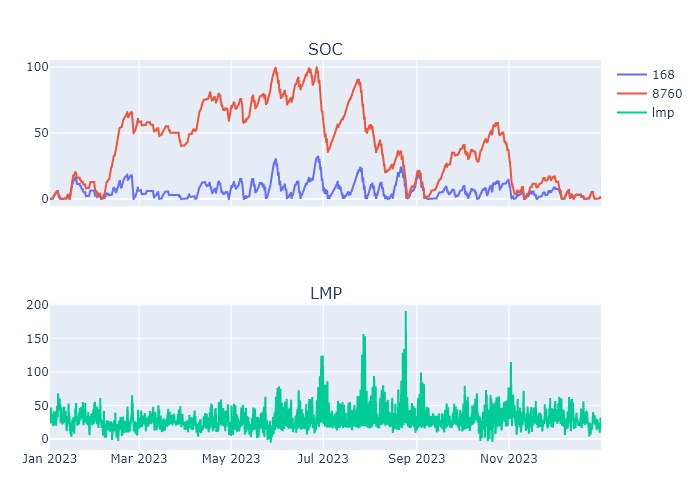

In [17]:
fig3 = make_subplots(rows=2, cols=1, shared_xaxes=true, subplot_titles=["SOC" "LMP"])

add_trace!(fig3, scatter(x=results100HR168F.interval_start_est, y=results100HR168F.SOCstart, mode="lines", name="168"), row=1, col=1)
add_trace!(fig3, scatter(x=results100HR8760F.interval_start_est, y=results100HR8760F.SOCstart, mode="lines", name="8760"), row=1, col=1)
add_trace!(fig3, scatter(x=results100HR8760F.interval_start_est, y=results100HR8760F.minnHubLmp, mode="lines", name="lmp"), row=2, col=1)

fig3

In [18]:
# output = @select results :interval_start_est :minnHubLmp :charging :discharging :SOCstart :SOCend :cashFlow;

In [19]:
# CSV.write("8hr-$analysisYear-cap-bonus-battery-optimization-results.csv", output)

In [20]:
# # Multicase Optimization
# cases = [
#     (prices=misoPrices, energyCap=120, pwrRt=120),  # 1 hr 
#     (prices=misoPrices, energyCap=60, pwrRt=60),   # 1 hrs
#     (prices=misoPrices, energyCap=120, pwrRt=60),   # 2 hrs
#     (prices=misoPrices, energyCap=60, pwrRt=30),   # 2 hrs
#     (prices=misoPrices, energyCap=120, pwrRt=30),   # 4 hrs
#     (prices=misoPrices, energyCap=60, pwrRt=15),   # 4 hrs
#     (prices=misoPrices, energyCap=20, pwrRt=10),   # 4 hrs
#     (prices=misoPrices, energyCap=10, pwrRt=5),    # 4 hrs
# ];

# solutions = NamedTuple[]
# for c in cases
#     s = solveStorageOptimization(c.prices, c.energyCap, c.pwrRt)
#     push!(solutions, (Capacity=c.energyCap, PowerRating=c.pwrRt, s.revenue))
# end
# # DataFrame(solutions)

In [21]:
# # Single case optimization
# solution = solveStorageOptimization(misoPrices, 40, 10; roundTripEfficency=100, selfDischarge=0)
# # Time series results parsed into an DataFrame
# solution

In [22]:
# fig1 = plot(
#     [
#         scattergl(x=results.interval_start_est, y=results.minnHubLmp, name="MISO DA LMP", mode="lines", line=attr(shape="hv")),
#         bar(
#             x=results.interval_start_est, y=results.storageDispatch, 
#             name="Storage Dispatch", 
#             offset=1, width=3.6e+6,
#             yaxis="y2"
#         ),
#         bar(x=[nothing], y=[nothing], mode="markers", name="Resource Adequacy Hour", marker=attr(size=7, color="white", symbol="square", line=attr(width=1, color="Black")))
#     ],
#     Layout(
#         title_text="8-hr Storage Dispatch",
#         xaxis=attr(
#             title="Date",
#             dtick="D1"
#         ),
#         yaxis=attr(
#             title="LMP (\$/MWh)",
#             # fixedrange=true,
#             range=[-50,250],
#         ),
#         yaxis2=attr(
#             title="Storage Dispatch (MWh) <br> (<--- Charging | Discharging --->)",
#             # fixedrange=true,
#             overlaying="y",
#             tickmode="sync",
#             side="right",
#             range=[-25,125],
#         ),
#         legend=attr(x=.9, y=1)
#     )
# )

# for row in eachrow(results)
#     if row.ra_hour_north_central == 1
#         add_vrect!(
#             fig1, 
#             Dates.format(row.interval_start_est, "yyyy-mm-dd HH:MM:SS"), Dates.format(row.interval_start_est + Hour(1), "yyyy-mm-dd HH:MM:SS"), 
#             # fillcolor="LightSalmon", opacity=0.5, 
#             layer="below", line_width=1
#             )
#     end
# end

# fig1